# SNLO Tutorial 5 - SHG Demo

We start with the usual imports and definitions.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import colorcet as cc

import snlo.pulses as pulses
import snlo.materials as materials
import snlo.waveguides as waveguides

from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
MHz = 1e6
GHz = 1e9
THz = 1e12
pJ = 1e-12
fJ = 1e-15
mW = 1e-3
uW = 1e-6

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Time/Frequency Grids
We did this in a previous notebook.

In [2]:
#Let's set the bandwdith
λ_start = 800*nm
λ_stop = 3*um
f_max = c/λ_start
f_min = c/λ_stop
BW = f_max - f_min

N = 2**10 #I usually pick this one to be a power of 2 but that's not strictly necessary

T = N/BW #Time window size
Δt = 1/BW #Time resolution
t_start = -T/2 #Start of time window
#These are the time and frequency vectors 
t = t_start + np.arange(0, T, step=Δt)
f = fftfreq(N, Δt)

f_ref = (f_max + f_min)/2  #This variable will be supplied to several plotting functions
f_abs = f + f_ref #This is the absolute frequency vector
λ = c/f_abs #This is the wavelength vector

## Pump Pulse

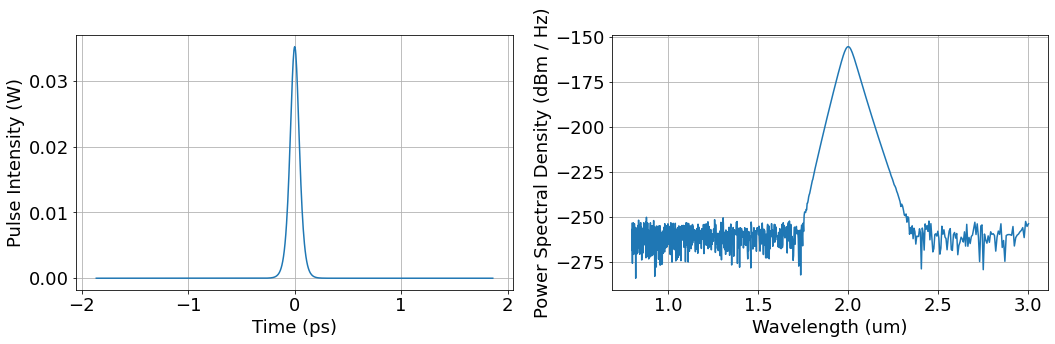

In [3]:
λp = 2*um #Center wavelegnth of the pulse
Pavg = 1*uW #Average Power
τ = 100*fs #Pulse width:
frep = 250*MHz #Repetition rate
N_dB = 100 #Noise level (relative to the pulse peak)

pump = pulses.sech_pulse(t, τ, Pavg=Pavg, f_ref=f_ref, f0=c/λp, Npwr_dB=N_dB, frep=frep)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
ax1 = pump.plot_magsq(ax=ax1, t_unit='ps')
ax2 = pump.plot_PSD(ax=ax2, f_unit='um')

# Waveguide

<html>
  <body>
    <img src="Waveguide_geometry.png" alt="Waveguide Geometry" width="40%">
  </body>
</html>

In [4]:
width = 1800*nm
hLN = 700*nm
hetch = 350*nm

wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch, tf_material = 'LN_MgO_e',
                         box_material = 'SiO2',  clad_material = 'Air')

In [5]:
pp = 5.18*um #Poling period
L = 4*mm #Waveguide length
Alpha = 0.1 # attentuation coefficient (dB/cm)
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m

def poling_func(z):
    return np.sign(np.cos(z*2*pi/pp))

#Here's where we actually "load" these to the waveguide
wg.add_poling(poling_func)
wg.set_nonlinear_coeffs(N = 1, X0 = 1.1e-12)
wg.set_length(L)
wg.set_loss(alpha)

## Nonlinear simulation

Finally, we can run the simulation. The method propagate_NEE takes a pulse object, a step size, and a reference velocity for the moving frame and outputs a pulse and it's evolution along the crystal.

In [6]:
h = pp/10 #Step size
v_ref = 1/wg.beta1(λp/2) #So the simulation is stationary at the second harmonic

[pulse_out, pulse_evol_full] = wg.propagate_NEE(pump, h, v_ref=v_ref, zcheck_step = 1*mm)

Using 4x upsampling.
Crystal length = 4.00 mm
Step size = 0.52 um
Number of steps = 7722
Completed propagation along 1.00 mm (2.0 s)
Completed propagation along 2.00 mm (1.9 s)
Completed propagation along 3.00 mm (1.9 s)
Completed propagation along 4.00 mm (2.0 s)
Total time = 8.3 s


In [7]:
#Allows good to check if energy is not increasing
print('Input pulse energy = %0.3f pJ' %(pump.energy_td()/pJ))
print('Output pulse energy = %0.3f pJ' %(pulse_out.energy_td()/pJ))

Input pulse energy = 0.004 pJ
Output pulse energy = 0.004 pJ


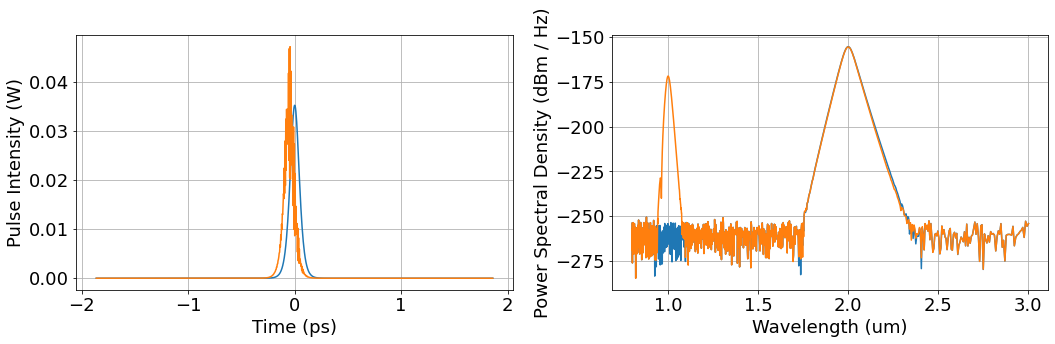

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
ax1 = pump.plot_magsq(ax=ax1, t_unit='ps')
ax1 = pulse_out.plot_magsq(ax=ax1, t_unit='ps')

ax2 = pump.plot_PSD(ax=ax2, f_unit='um')
ax2 = pulse_out.plot_PSD(ax=ax2, f_unit='um')